# NLP Portion

### Libraries to Install if missing

pip install wordcloud

pip install pyLDAvis

pip install gensim

pip install demoji

### Import Libraries

In [1]:
#Import necessary libraries
import pandas as pd
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis.gensim 

from sklearn.feature_extraction import text 
import datetime
#import demoji
#demoji.download_codes()

from datetime import datetime as dt

from nltk.stem import WordNetLemmatizer 
import nltk


warnings.simplefilter("ignore", DeprecationWarning)
from nltk.sentiment.vader import SentimentIntensityAnalyzer



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import Data

In [2]:
#Read in comments and movie data and merge them
alex_clusters = pd.read_csv('/home/jovyan/git/lf_capstone/utils/alex_clusters.csv')
comments = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data_concat/comments_concat.csv').iloc[:, 1:]

movie_dat_1 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/brand_source_affiliations_1k-10k.tsv', delimiter='\t')
movie_dat_2 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/brand_source_affiliations_10kplus.tsv', delimiter='\t')
movie_dat = pd.concat([movie_dat_1, movie_dat_2])

comments_with_movies = comments.merge(movie_dat, left_on='post_author_dcs_uid', right_on='data_profile_dcs_uid', how='left')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Filter out movies previously filtered in clustering
selected_movies = [x for x in movie_dat['brand_ods_id'].unique() if x in alex_clusters['brand_ods_id'].unique()]
comments_with_movies_cleaned = comments_with_movies[comments_with_movies.brand_ods_id.isin(selected_movies)]

### Defining Functions

In [4]:
# Function for retrieving comments for a particular movie. Takes in movie ID, comment data frame, 
# start and end date if applicable, outputs dataframe

def movie_comments(brand_ods_id, df, start_date = None, end_date = None):
    
    comments_only = df[(df['brand_ods_id'] == brand_ods_id)]
    comments_only['comment_posted_at'] = pd.to_datetime(comments_only['comment_posted_at'])
    if start_date == None:
        start_date = min(comments_only['comment_posted_at'])
    
    if end_date == None:
        end_date = max(comments_only['comment_posted_at'])

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    
    comments_fil = comments_only[['comment_id', 'comment_dcs_uid', 'post_dcs_uid', 'spec_channel', 'comment_posted_at',  'comment_message']]
    comments_unique = comments_fil.drop_duplicates(subset = 'comment_id')
    comments_unique = comments_unique.dropna(subset=['comment_message'])
    #comments_unique['comment_posted_at'] = pd.to_datetime(comments_unique['comment_posted_at'])
    comments_unique = comments_unique[(comments_unique['comment_posted_at'] >= start_date) & (comments_unique['comment_posted_at'] <= end_date)]

    return(comments_unique)

In [5]:
# Function for cleaning text, takes in text column name, comment dataframe, stopwords,
# outputs dataframe

def text_processing(text_column, df, words_to_remove):
    
    df[text_column] = df[text_column].astype(str)
    # Remove emojis
    df['comment_cleaned'] = df[text_column].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
    # Ensure string
    df['comment_cleaned'] = df['comment_cleaned'].astype(str)
    # Remove links
    df['comment_cleaned'] = df['comment_cleaned'].str.replace('http\S+|www.\S+', '', case=False)
    # Remove punctuation
    df['comment_cleaned'] = df['comment_cleaned'].map(lambda x: re.sub('[,@\.!?:_]|\\n', '', x))
    # Convert the titles to lowercase
    df['comment_cleaned'] = df['comment_cleaned'].map(str.lower)
    
    # Remove Leading and Trailing whitespace
    df['comment_cleaned'] = df['comment_cleaned'].map(str.strip)
    
    # Remove certain words + stop words
    pat = r'\b(?:{})\b'.format('|'.join(words_to_remove))
    df['comment_cleaned_without_stopwords'] = df['comment_cleaned'].str.replace(pat, '')
    df['comment_cleaned_without_stopwords'] = df['comment_cleaned_without_stopwords'].str.replace(r'\s+', ' ')
    
    # Remove leading and Trailing whitespace
    df['comment_cleaned_without_stopwords'] = df['comment_cleaned_without_stopwords'].map(str.strip)
    
    
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()

    def lemmatize_text(text):
        return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    df['text_lemmatized'] = df['comment_cleaned'].apply(lemmatize_text)
    df['text_lemmatized'] = df['text_lemmatized'].apply(' '.join)
    
    df['text_lemmatized_without_stopwords'] = df['comment_cleaned_without_stopwords'].apply(lemmatize_text)
    df['text_lemmatized_without_stopwords'] = df['text_lemmatized_without_stopwords'].apply(' '.join)

    return(df)

In [6]:
# Generates wordcloud of comments, takes in dataframe and column to generate a wordcloud of
def wordcloud_map(df, column):
    long_string = ','.join(list(df[column].values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1600, height=800)
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    wordcloud.to_image()
    return(wordcloud.to_image())

In [7]:
# Show the top X most common ngrams of a column
# Takes in dataframe, column of comments, ngram (1 is unigram, 2 bigram etc.), top X number
# Outputs plot of most common words, ngram dataframe, count data, and count vector
# Count data and the count vector can then be used to generate topic models

def ngram_count(df, column, ngram, top_number):
    
    c_vec = CountVectorizer(ngram_range=(ngram, ngram))

    # input to fit_transform() should be an iterable with strings
    ngrams = c_vec.fit_transform(df[column])

    # needs to happen after fit_transform()
    vocab = c_vec.vocabulary_

    count_values = ngrams.toarray().sum(axis=0)
    n_gram = []
    n_gram_count = []
    # output n-grams
    for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
        n_gram.append(ng_text)
        n_gram_count.append(ng_count)

    n_gram_df = pd.DataFrame(list(zip(n_gram, n_gram_count)), columns =['n_gram', 'count'])

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= 'Top ' + str(top_number) + ' Most Common Words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

    sns.barplot(x=n_gram_df['n_gram'][:top_number],
                y=n_gram_df['count'][:top_number], 
                palette='husl',
                data=n_gram_df)

    plt.xticks(rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
    return(n_gram_df, ngrams, c_vec)

In [8]:
# When generating topic models using LDA, prints the topics
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


In [9]:
# Generates sentiment scores (positive, negative, neutral) for each comment
# To be used after text_processing
# Takes in dataframe and text column, outputs dataframe
def sentiment_comments(df, text_column):
    sid = SentimentIntensityAnalyzer()
    df["sentiments"] = df[text_column].apply(lambda x: sid.polarity_scores(x))
    if 'compound' not in df.columns:
        df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
    
    # add number of characters column
    df["nb_imp_chars"] = df["comment_cleaned"].apply(lambda x: len(x))
    # add number of words column
    df["nb_imp_words"] = df["comment_cleaned"].apply(lambda x: len(x.split(" ")))

    return(df)

In [10]:
#Return the top positive/negative comments which have more than 5 significant words 
def parse_sentiment(df, sent, num):
    
    if sent.lower() == 'positive':
        return(df[df["nb_imp_words"] >= 5].sort_values("pos", ascending = False)[['comment_message','text_lemmatized_without_stopwords', 'pos']].head(num))
        
    elif sent.lower() == 'negative':
        return(df[df["nb_imp_words"] >= 5].sort_values("neg", ascending = False)[['comment_message','text_lemmatized_without_stopwords', 'neg']].head(num))


## Example Use Case: Sonic Movie - Good vs Bad comments

### Searching for Sonic Movie information and Movie ID Number

In [11]:
movie_dat[movie_dat['replace'].str.contains("Sonic")]

,brand_ods_id,replace,released_on,ticker_symbol,genres,data_profile_dcs_uid,data_profile_channel_type,data_profile_source_type,data_affiliation_active_flag,data_affiliation_start_date_key,data_affiliation_end_date_key
93,82057,Sonic The Hedgehog (2020),2020-02-14,VIA,"Action, Adventure, Animation",a8ee7a565cb098206516cb60154d3bd8,facebook,search_term,t,101,7769
174,82057,Sonic The Hedgehog (2020),2020-02-14,VIA,"Action, Adventure, Animation",707d4528a424e60a3c9de60f31d2a80d,facebook,page,t,101,7769
354,82057,Sonic The Hedgehog (2020),2020-02-14,VIA,"Action, Adventure, Animation",3fb2ca879bc6d5724621117d8ba54cce,twitter,search_term,t,101,7769
384,82057,Sonic The Hedgehog (2020),2020-02-14,VIA,"Action, Adventure, Animation",4e7364895655334194cde1a6c2d3821f,instagram,page,t,101,7769
801,82057,Sonic The Hedgehog (2020),2020-02-14,VIA,"Action, Adventure, Animation",67287441068d1ba99f40be55f087adb5,twitter,handle,t,101,7769
855,82057,Sonic The Hedgehog (2020),2020-02-14,VIA,"Action, Adventure, Animation",bbc38a99521c06d4793a2a5ffa67f995,twitter,search_term,t,101,7769
1287,82057,Sonic The Hedgehog (2020),2020-02-14,VIA,"Action, Adventure, Animation",cb1183b926b719125ebe89468e059be1,twitter,search_term,t,101,7769


### Period of Good Sonic Comments 

In [12]:
#Finding Comments for the Sonic Movie for defined period (Oct 2019 to Jan 2020)
good_sonic = movie_comments(82057, comments_with_movies_cleaned, '2019-10', '2020-01-31')  

#Adding custom stopwords to default english stopwords
my_stop_words = text.ENGLISH_STOP_WORDS.union(['sonic', 'movies', 'movie', 'sonicmovie', 'hedgehog', 'sonichedgehog']) 

#Cleaning and Processing Comments
good_sonic = text_processing('comment_message',good_sonic, my_stop_words) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


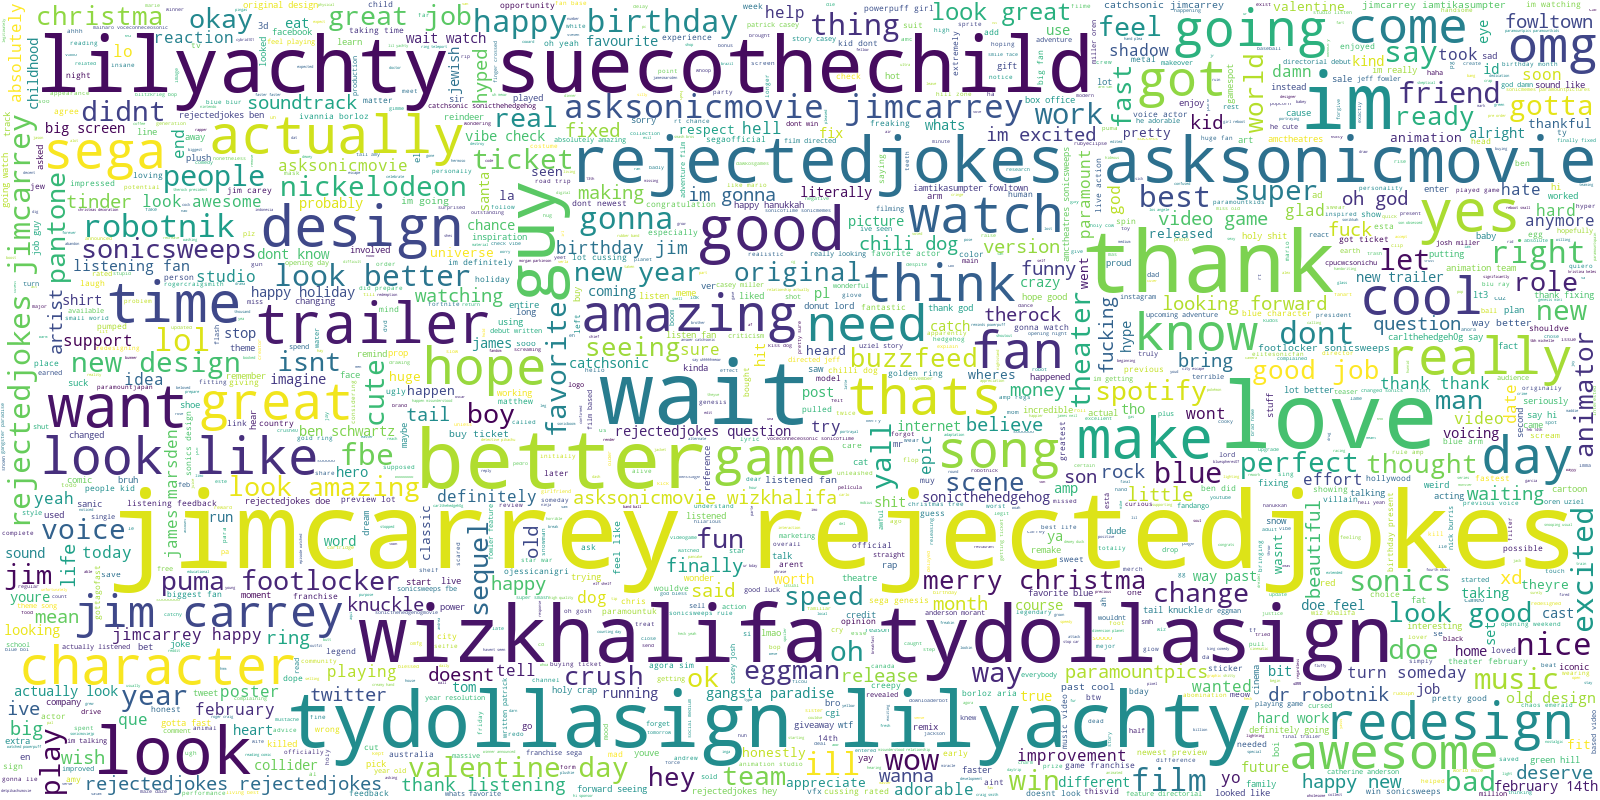

In [13]:
#Generating Word Cloud
wordcloud_map(good_sonic, 'text_lemmatized_without_stopwords') 

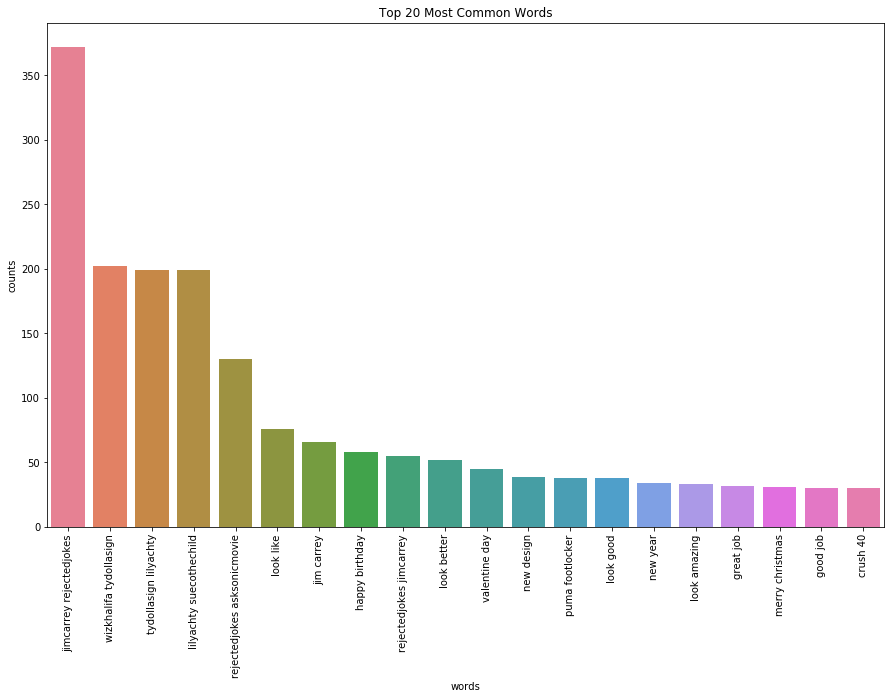

In [14]:
#Looking at most common 20 bigrams
good_sonic_bigrams, count_data, count_vectorizer = ngram_count(good_sonic, 'text_lemmatized_without_stopwords', 2, 20)

In [15]:
#Generating topic models using LDA

#Setting seed so the models do not change
np.random.seed(1234)

# Tweak the two parameters below depending on topic distribution
number_topics = 4
number_words = 4

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data) #Input count_data output from ngram function output

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words) #Input count_vectorizer from ngram function output

Topics found via LDA:

Topic #0:
jimcarrey rejectedjokes rejectedjokes asksonicmovie look like look better

Topic #1:
jimcarrey rejectedjokes new year look like happy new

Topic #2:
wizkhalifa tydollasign lilyachty suecothechild tydollasign lilyachty jimcarrey rejectedjokes

Topic #3:
jimcarrey rejectedjokes merry christmas im excited rejectedjokes asksonicmovie


In [16]:
#Saving topic models as html
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, 'good_sonic_topic_model_animation.html')

#### Sentiment analysis of comments

In [17]:
#Generating sentiment of all comments
good_sonic = sentiment_comments(good_sonic, 'comment_message')

In [18]:
# Setting pandas to show the full width of the column without cutting off
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [19]:
# Highest positive sentiment reviews (with more than 5 words)
parse_sentiment(good_sonic, "positive", 10)

,comment_message,text_lemmatized_without_stopwords,pos
3542877,Wow cool. I love that.😍👍🙂,wow cool love,0.912
14466697,Done & Thanks! Happy Holidays!,thanks happy holiday,0.907
10613681,Awesome Much better Thank you,awesome better thank,0.826
8241052,@SonicMovie Yes yes and YES!,yes yes yes,0.820
10794466,Happy Holidays and Merry Christmas Sonic :3,happy holiday merry christmas 3,0.814
5659951,@SonicMovie I LOVE IT I LOVE IT I LOVE IT,love love love,0.787
7451393,Happy Holiday Sonic The Awesome 🌭🔵💨💨💯💯,happy holiday awesome,0.778
6883619,Happy to friend you my hero,happy friend hero,0.778
3700560,@SonicMovie @FBE Is beautiful ♡ Hug hug,fbe beautiful hug hug,0.771
13301296,Already did. Hope I win.,did hope win,0.770


In [20]:
# Highest negative sentiment reviews (with more than 5 words)
parse_sentiment(good_sonic, "negative", 10)

,comment_message,text_lemmatized_without_stopwords,neg
7842335,He brutally murdered that guy.,brutally murdered guy,0.737
6247446,No. Just no. Please no,just,0.667
13504867,@SonicMovie SONIC WHAT THE HELL YOU KILLED HIM,hell killed,0.638
8143228,I don't want ur help,dont want ur help,0.635
12976376,@SonicMovie sonic the hedgehog commits a violent murder,commits violent murder,0.628
13910585,"I hate the stupid phrase, “I can’t.” It’s so frickin’ stupid.",hate stupid phrase frickin stupid,0.600
13671730,U killed all toes bays,u killed toe bay,0.600
13887712,@SonicMovie sonic no this is awful,awful,0.565
12226919,No. We need Crush 40.,need crush 40,0.559
9787954,Who the hell are they?,hell,0.535


### Period of Bad Sonic Comments 

In [21]:
#Finding Comments for the Sonic Movie for defined period (March 2019 to June 2019)
bad_sonic = movie_comments(82057, comments_with_movies_cleaned, '2019-03', '2019-06-30')

#Adding custom stopwords to default english stopwords
my_stop_words = text.ENGLISH_STOP_WORDS.union(['sonic', 'movies', 'movie', 'sonicmovie', 'hedgehog', 'sonichedgehog'])

#Cleaning and Processing Comments
bad_sonic = text_processing('comment_message',bad_sonic, my_stop_words)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


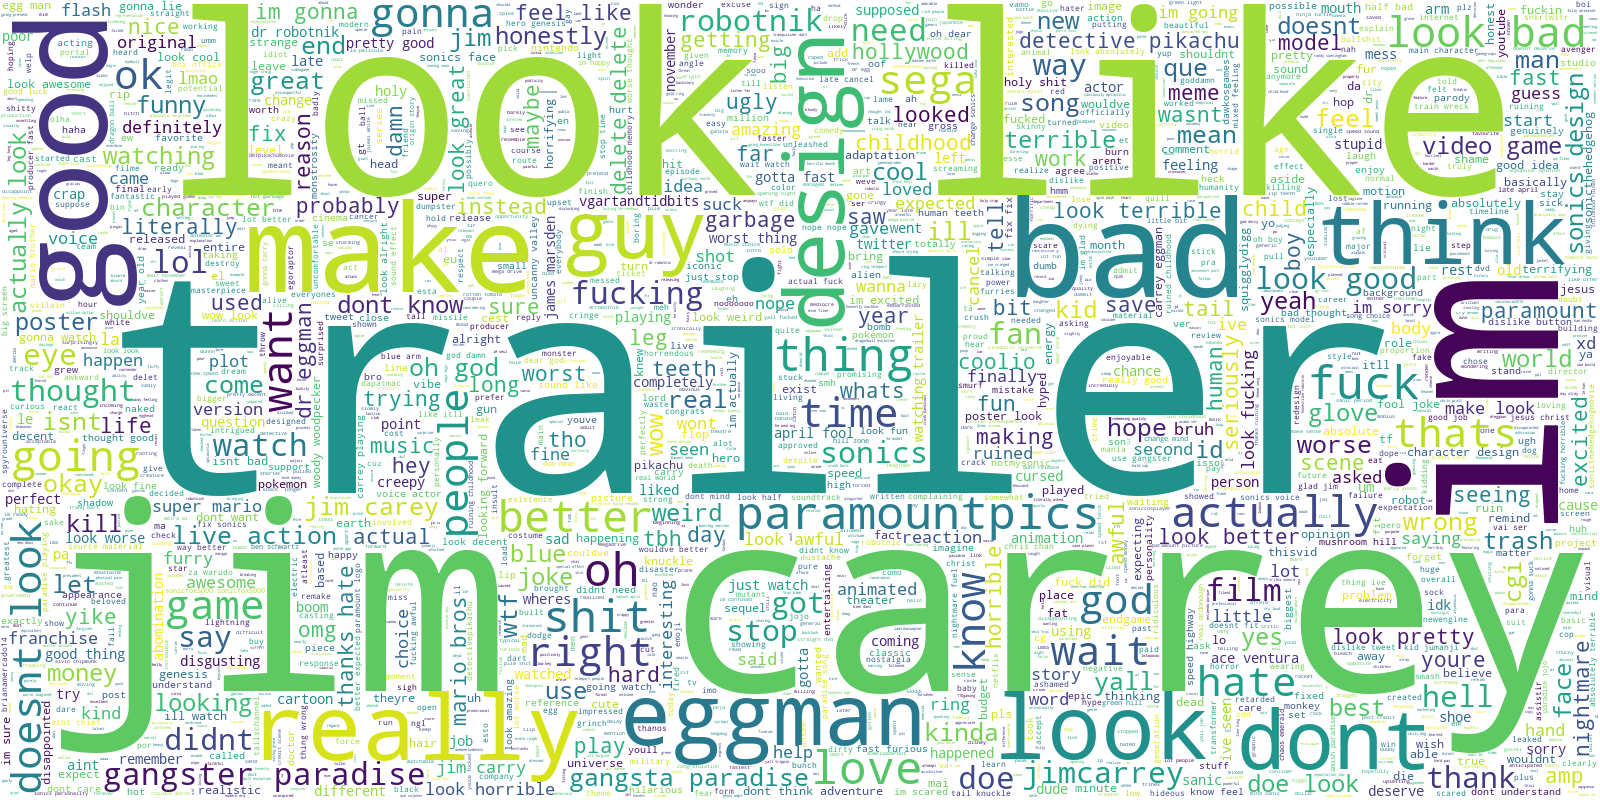

In [22]:
#Generating Word Cloud
wordcloud_map(bad_sonic, 'text_lemmatized_without_stopwords')

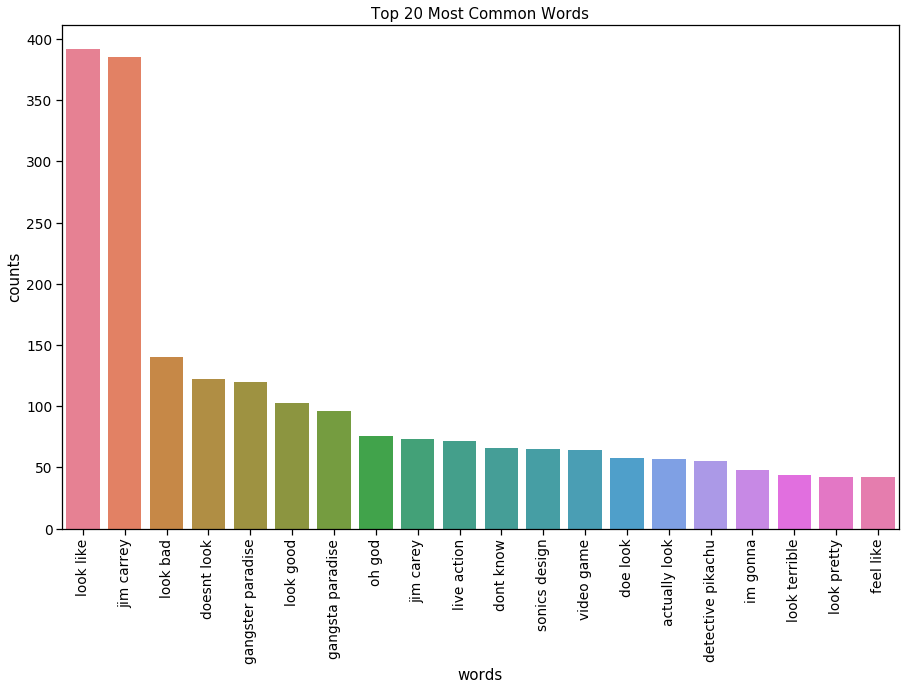

In [23]:
#Looking at most common 20 bigrams
bad_sonic_bigrams,count_data, count_vectorizer = ngram_count(bad_sonic, 'text_lemmatized_without_stopwords', 2, 20)

In [24]:
np.random.seed(1234)

# Tweak the two parameters below depending on topic distribution
number_topics = 6
number_words = 6
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
jim carrey gangsta paradise look like look bad did just just watch

Topic #1:
jim carrey look like oh god gangster paradise look good live action

Topic #2:
look like jim carrey doe look delete delete thanks hate doesnt look

Topic #3:
jim carrey look like look bad jim carey live action doesnt look

Topic #4:
look like dont know look better gangster paradise look pretty look terrible

Topic #5:
look bad doesnt look jim carrey look like look good im gonna


Saving graphs to html

In [25]:
#Saving the topic model
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, 'bad_sonic_topic_model_animation.html')

#### Sentiment Analysis of Comments

In [26]:
# Generating sentiment for all comments
bad_sonic = sentiment_comments(bad_sonic, 'comment_message')

In [27]:
# highest positive sentiment reviews (with more than 5 words)
parse_sentiment(bad_sonic, "positive", 10)

,comment_message,text_lemmatized_without_stopwords,pos
8354638,@SonicMovie @sonic_hedgehog Love love love,love love love,0.863
13443671,@SonicMovie Okay that's pretty awesome,okay thats pretty awesome,0.821
12287487,@SonicMovie I loved!!! Very cool,loved cool,0.787
7181877,"@SonicMovie God, please, have mercy!",god mercy,0.782
11373956,@SonicMovie Yes! Protect this precious Sonic,yes protect precious,0.756
8926569,@SonicMovie @sonic_hedgehog HAHAHA CORPERATISM YAY,hahaha corperatism yay,0.738
11517242,@SonicMovie He looks pretty good here thank god!,look pretty good thank god,0.733
12201733,@SonicMovie LOL LOL this movie!!!!,lol lol,0.733
10488887,@SonicMovie He's beautiful I love him,he beautiful love,0.730
12864024,@SonicMovie @VGArtAndTidbits Gangsters Paradise lmao,vgartandtidbits gangster paradise lmao,0.730


In [28]:
# lowest negative sentiment reviews (with more than 5 words)
parse_sentiment(bad_sonic, "negative", 10)

,comment_message,text_lemmatized_without_stopwords,neg
9598585,@SonicMovie NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO https://t.co/9Wyf5rQh1X,,0.991
12771512,@SonicMovie No. No. No. No. No. No. No. :(,,0.948
12737688,"@SonicMovie No, no, no, no, no",,0.917
11758115,@SonicMovie No no no no no,,0.917
8355327,@SonicMovie Oh no no no no no no no no no,oh,0.908
12737134,@SonicMovie No no no no no no no no no no no no.... No. Just no.,just,0.905
8570755,@SonicMovie NO NO NO NO NO NO NOOOOOOOOOOOOO,nooooooooooooo,0.898
7415675,@SonicMovie No. No. No. no. No. No. No? Yes? No. No!,yes,0.847
8926029,"@SonicMovie No, no, no, no and a big fat HELL NO!!",big fat hell,0.815
10543027,@SonicMovie Wtf i hate you,wtf hate,0.789
